## Kernel Method Data Challenge

## Imports

In [3]:
%pip install numpy matplotlib pandas

  Using cached pandas-3.0.1-cp314-cp314-win_amd64.whl.metadata (19 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-3.0.1-cp314-cp314-win_amd64.whl (9.9 MB)
Using cached tzdata-2025.3-py2.py3-none-any.whl (348 kB)

   ---------------------------------------- 0/2 [tzdata]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
 

## Load data

In [8]:
import pandas as pd
import numpy as np


def load_data(file_path : str):
    """
    Load data of the file path
    """
    print("Load data")
    X_train = pd.read_csv(file_path + '/Xtr.csv', header=None, usecols=range(3072)).values.astype('float32')
    X_test = pd.read_csv(file_path + '/Xte.csv', header=None, usecols=range(3072)).values.astype('float32')
    y_train = pd.read_csv(file_path + '/Ytr.csv', usecols=[1]).values.ravel()
    
    return X_train, X_test, y_train


X_train, X_test, y_train = load_data("./data")

Load data


In [35]:
def split_data_train_val(X_train,y_train,val_size = 0.2,seed=42):
    np.random.seed(seed)

    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)

    split_idx = int(X_train.shape[0]*(1 -val_size))
    train_idx = indices[:split_idx]
    val_idx = indices[split_idx:]

    return X_train[train_idx], X_train[val_idx], y_train[train_idx], y_train[val_idx]

X_train_fold, X_val_fold, y_train_fold, y_val_fold = split_data_train_val(X_train, y_train,val_size=0.1)

## Visualize data 


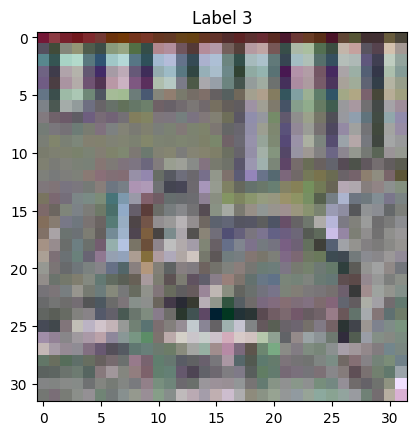

In [36]:
import matplotlib.pyplot as plt

def vec2img(row) : 
    """
    Transform a vector of data to a image of shape (32,32,3) 
    """
    red = row[0:1024].reshape(32, 32)
    green = row[1024:2048].reshape(32, 32)
    blue = row[2048:3072].reshape(32, 32)

    img = np.dstack((red,green,blue))

    img_min, img_max = img.min(), img.max()
    img = (img - img_min) / (img_max - img_min)

    return img

def plot_img(img,label) :
    """
    Plot a image 
    """

    plt.figure()
    plt.imshow(img)
    plt.title(f"Label {label}")
    plt.show()


first_img = vec2img(X_train[9])
label = y_train[9]
plot_img(first_img,label)

### Accuracy

In [37]:
def get_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100


### Generate Submission

In [ ]:
import os 

def generate_submission(predictions,folder_name='submissions',model_name ="final", filename='Yte_pred.csv'):

    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    file_name = model_name + filename
    file_path = os.path.join(folder_name,file_name)

    df = pd.DataFrame({'Prediction': predictions})
    df.index += 1
    df.to_csv(file_path, index_label='Id')


# --- Exemple d'utilisation dans ton script ---
# y_pred = classifier.predict(Xte)
# save_submission(y_pred, folder_name='my_results', model_name='rbf_poly_mix')

## Classification Algorithms 

### Kernel Ridge Regression


To start with and have a baseline we implement the easier regression : the kernel ridge regression. To do classification on 10 differents classes we will use One-vs-Rest strategy. 

In [38]:
class KRRClassifier:
    """ Kerner Ridge Regression general class""" 
    def __init__(self, kernel_func ,reg= 0.1,num_classes = 10, **kernel_params):
        self.kernel_func = kernel_func
        self.reg = reg
        self.kernel_params = kernel_params
        self.alpha = None
        self.X_train = None
        self.num_classes = num_classes

    def fit(self,X,y) : 
        self.X_train = X
        n = X.shape[0]
        K = self.kernel_func(X,X,**self.kernel_params)
        
        # One hot encoding matrix for classes
        Y_one_hot = np.zeros((n, self.num_classes))
        Y_one_hot[np.arange(n), y.astype(int)] = 1

        self.alpha = np.linalg.solve(K + self.reg * np.eye(n), Y_one_hot)
        
    def predict(self,X_test) : 
        K_test = self.kernel_func(X_test,self.X_train,**self.kernel_params)
        scores = np.dot(K_test, self.alpha)
        return np.argmax(scores, axis=1)


#### Kernels Definition

In [53]:
import numpy as np

def rbf_kernel(X1, X2, gamma=0.01):
    sq_norm_X1 = np.sum(X1**2, axis=1).reshape(-1, 1)
    sq_norm_X2 = np.sum(X2**2, axis=1)
    distances = sq_norm_X1 + sq_norm_X2 - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * distances)

def linear_kernel(X1, X2):
    return np.dot(X1, X2.T)

def polynomial_kernel(X1, X2, degree=2, coef0=0.05):
    return (np.dot(X1, X2.T) + coef0) ** degree


#### Test the Kernel

In [54]:
# Classic Polynomial
model_rbf = KRRClassifier(polynomial_kernel, reg=0.1,num_classes=10)
model_rbf.fit(X_train_fold, y_train_fold)

predictions = model_rbf.predict(X_val_fold)
acc = get_accuracy(predictions,y_val_fold)

print(f"Précision sur le dataset d'évaluation : {acc:.2f}%")

Précision sur le dataset d'évaluation : 31.00%


In [ ]:
predictions = model_rbf.predict(X_test)
generate_submission(predictions,)